# Exercises

For the exam, please complete two of these exercise (don't pick both Q1 and Q2, too easy)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# Set font sizes using rcParams
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

## Q3: Basins of attraction

Consider the function

$$q(x) = x^3 - 2x^2 - 11x + 12$$

This has 3 roots has you should find them all. This equation is known to cause problems for some root-finding methods  becauses it exhibits [basis of attraction](https://en.wikipedia.org/wiki/Newton%27s_method#Basins_of_attraction) -- very closely spaced initial guesses leave to very different roots.

Use the scipy `optimize.brentq` method to find the roots.  You might need to play around with the intervals to find all 3 roots (try plotting the function to help)

In [52]:
from scipy import optimize

found root -3.000
found root 1.000
found root 4.000


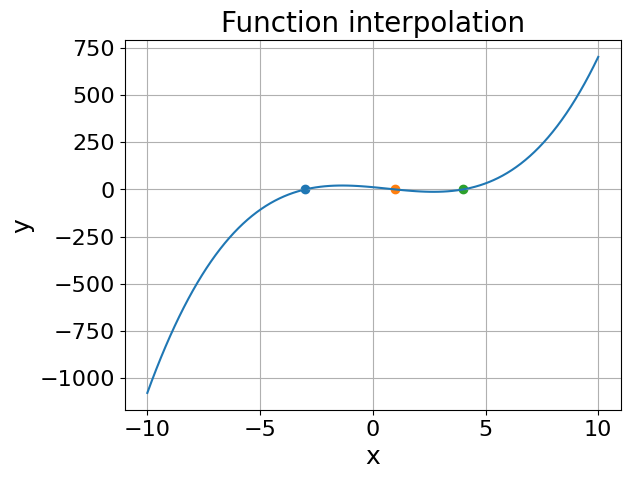

In [53]:
def f(x):
    return x**3 - 2 * x**2 - 11 * x + 12
x = np.linspace(-10,10,100)
y = f(x)
bound = [-5,0,2.5,5]

for i in range(3):  
    root, r = optimize.brentq(f, bound[i], bound[i+1], full_output=True)
    if r.converged:
        print(f"found root {root:.3f}")
        plt.scatter(root, f(root))

plt.plot(x,y)
plt.grid()
plt.xlabel("x", fontsize=18)
plt.ylabel("y", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Function interpolation", fontsize=20)
plt.show()

## Q5: Planetary orbits

We want to consider planetary orbits.  To do this, we need to solve Newton's second law together with Newton's law of gravity.  If we restrict ourselves to the x-y plane, then there are 4 quantities we need to solve for: $x$, $y$, $v_x$, and $v_y$.  These evolve according to:

\begin{align*}
\frac{dx}{dt} &= v_x \\
\frac{dy}{dt} &= v_y \\
\frac{dv_x}{dt} &= a_x = -\frac{GM_\star x}{r^3} \\
\frac{dv_y}{dt} &= a_y = -\frac{GM_\star y}{r^3}
\end{align*}

To integrate these forward in time, we need an initial condition for each quantity.  We'll setup our system such that the Sun is at the origin (that will be one focus), and the planet begins at perihelion and orbits counterclockwise. 

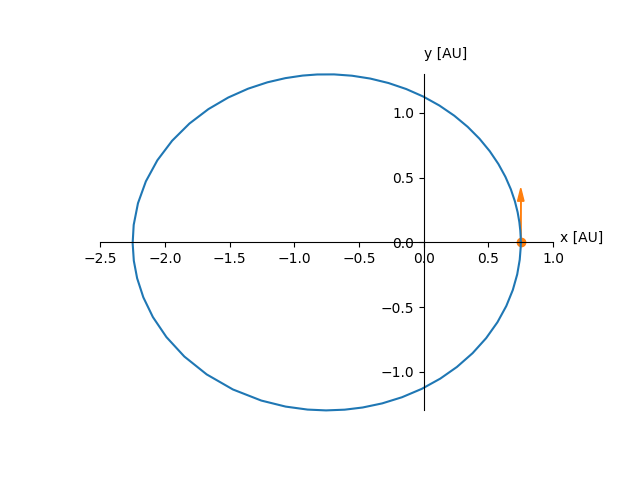

The distance of perihelion from the focus is:

$$r_p = a (1 - e)$$

where $a$ is the semi-major axis and $e$ is the eccentricity.  The perihelion velocity is all in the $y$ direction and is:

$$v_y = v_p = \sqrt{\frac{GM_\star}{a} \frac{1+e}{1-e}}$$

We'll work in units of AU, years, and solar masses, in which case, $GM_\star = 4\pi^2$ (for the Sun).  

Your initial conditions should be:

  * $x(t=0) = r_p$
  * $y(t=0) = 0$
  * $v_x(t=0) = 0$
  * $v_y(t=0) = v_p$

Use the scipy ODE integration methods to integrate an orbit and plot it

In [54]:
from scipy import integrate

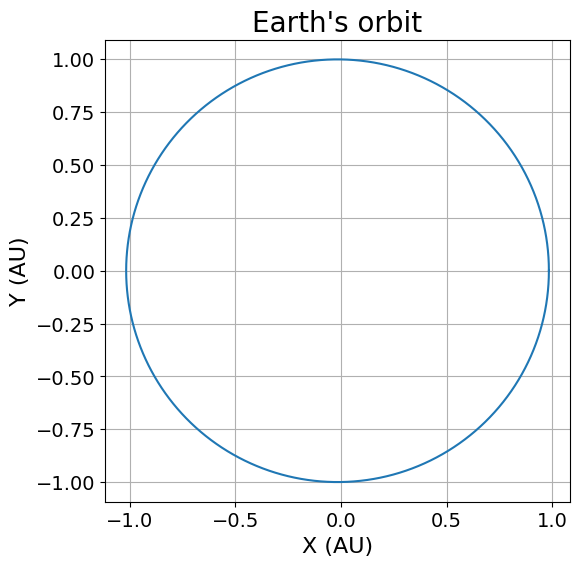

In [56]:
# GM for the Sun
GM = 4*np.pi**2
# Earth's orbit parameters
e = 0.0167
a = 1.0000010178

def eqs(t,x):
    r = (x[0]**2+x[1]**2)**0.5
    xdot = x[2]
    ydot = x[3]
    vxdot = - GM * x[0] / r**3
    vydot = - GM * x[1] / r**3
    return np.array([xdot, ydot, vxdot, vydot])

# from Kepler's third law: a**3 / T**2 = GM / (4*pi**2) = 1
tmax = np.sqrt(a**3)
dt = 0.001

# initial condition
rP = a*(1-e)
vP = np.sqrt(GM/a*(1+e)/(1-e))
X0 = [rP, 0, 0, vP]

r = integrate.solve_ivp(eqs, (0.0, tmax), X0,
                        method="RK45", dense_output=True, atol=1e-8, rtol=1e-8)

ts = np.arange(0.0, tmax, dt)

X = r.sol(ts)

fig = plt.figure(figsize=(6,6))
plt.plot(X[0,:], X[1,:])
plt.title("Earth's orbit")
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.grid()
plt.axis("equal")
plt.show()

## Q6: Damped driven pendulum and chaos

There are a large class of ODE integration methods available through the `scipy.integrate.ode()` function.  Not all of them provide _dense output_ -- most will just give you the value at the end of the integration.  

The explicit Runge-Kutta integrator will give you access to the solution at intermediate points and provides methods to interpolate to any value.  You enable this via `dense_output=True`.

The damped driven pendulum obeys the following equations:

$$\dot{\theta} = \omega$$

$$\dot{\omega} = -q \omega - \sin \theta + b \cos \omega_d t$$

here, $\theta$ is the angle of the pendulum from vertical and $\omega$ is the angular velocity.  $q$ is a damping coefficient, $b$ is a forcing amplitude, and $\omega_d$ is a driving frequency.

Choose $q = 0.5$ and $\omega_d = 2/3$.

Integrate the system for different values of $b$ (start with $b = 0.9$ and increase by $0.05$, and plot the results ($\theta$ vs. $t$).  Here's a RHS function to get you started:

In [57]:
def rhs(t, Y, q, omega_d, b):
        """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
        f = np.zeros_like(Y)
        
        f[0] = Y[1]
        f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

        return f

Note that the pendulum can flip over, giving values of $\theta$ outside of $[-\pi, \pi]$.  The following function can be used to restrict it back to $[-\pi, \pi]$ for plotting.

In [58]:
def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

Write a function that takes an initial angle, $\theta_0$, and integrates the system and returns the solution.

Note, the righthand side function, `rhs`, takes additional arguments that you need to pass through the integrator.  The preferred method to do this with the `solve_ivp()` interface appears to be to use `functools.partial()`, as:
```
from functools import partial

r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b), ...)
```

Some values of $b$ will show very non-periodic behavior.  To see chaos, integrate two different pendula that are the same except for $\theta_0$, with only a small difference between then (like 60 degrees and 60.0001 degrees.  You'll see the solutions track for a while, but then diverge.

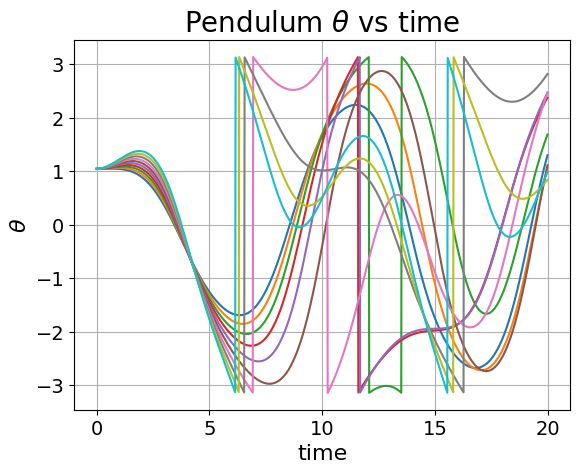

In [92]:
from functools import partial

q = 0.5
omega_d = 2/3
tmax = 20
dt = 0.02
ts = np.arange(0.0, tmax, dt)

def pendulum(theta, N_PEND = 10):
    Xs = []
    for i in range(N_PEND):
        r = integrate.solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=0.9+i*0.05), 
                                (0.0, tmax), [theta, 0], 
                                method="RK45", dense_output=True)
        Xs.append(r.sol(ts)[0])
    return Xs

X = pendulum(np.pi/3)
plt.figure()
for x in X:
    plt.plot(ts, restrict_theta(x))
plt.title(r'Pendulum $\theta$ vs time')
plt.xlabel('time')
plt.ylabel(r'$\theta$')
plt.grid()
plt.show()

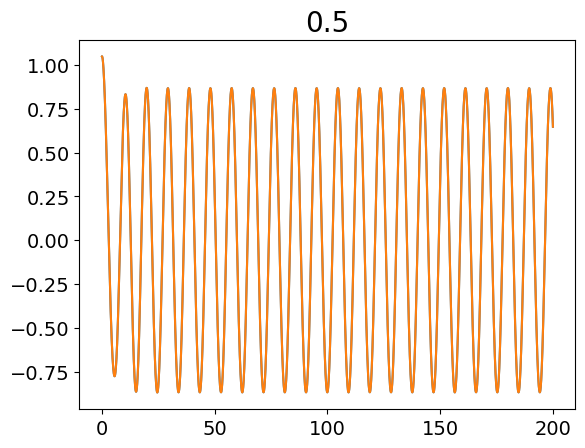

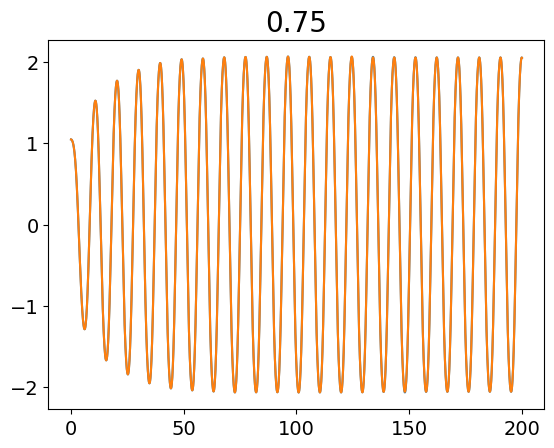

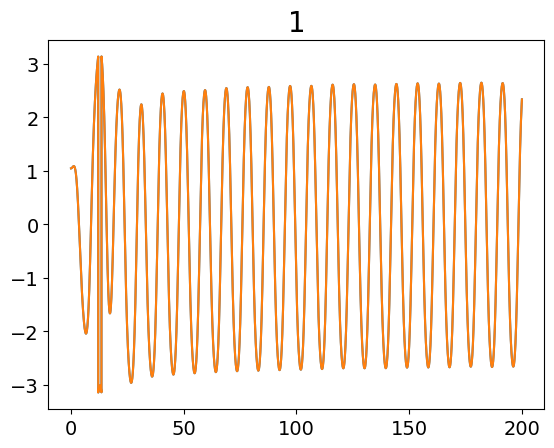

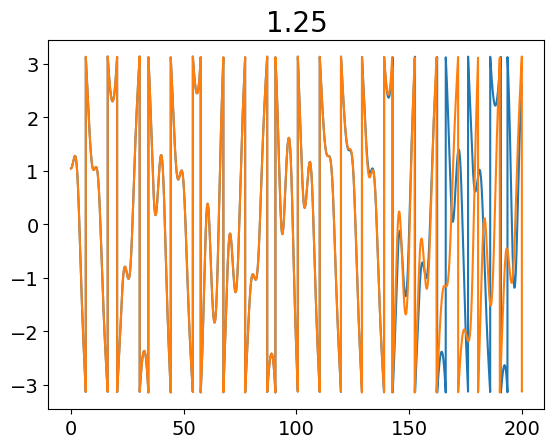

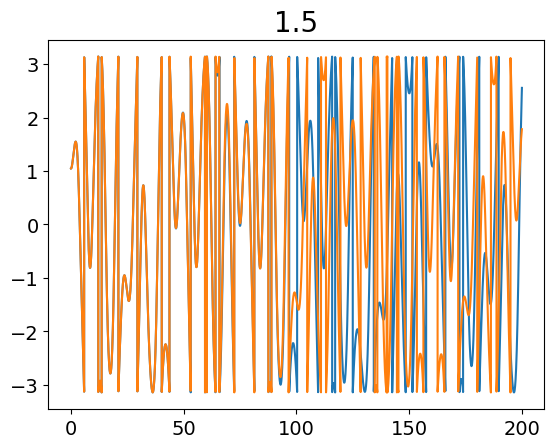

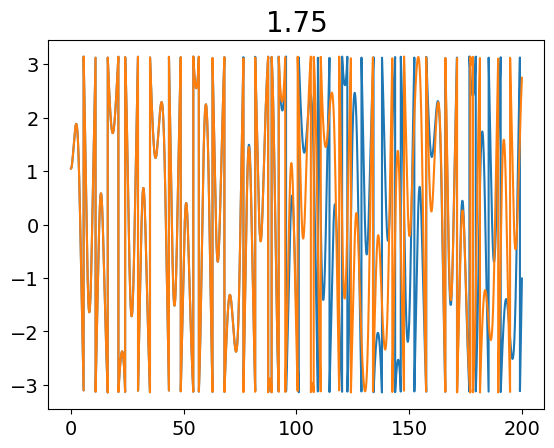

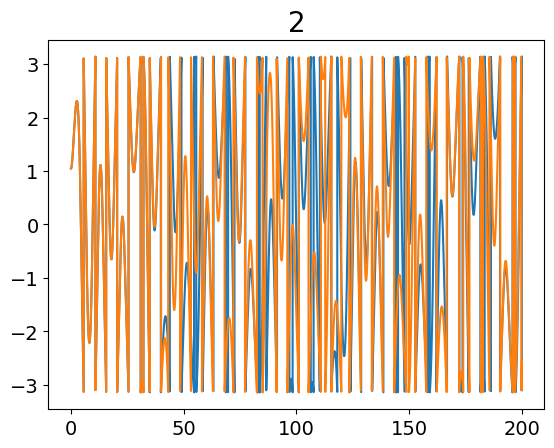

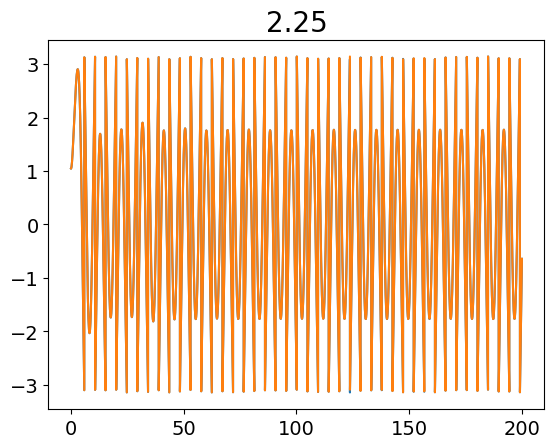

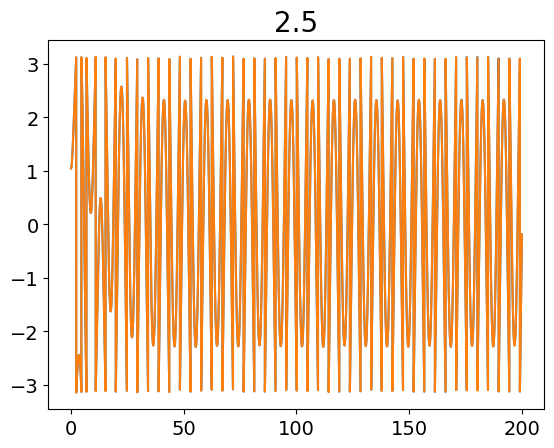

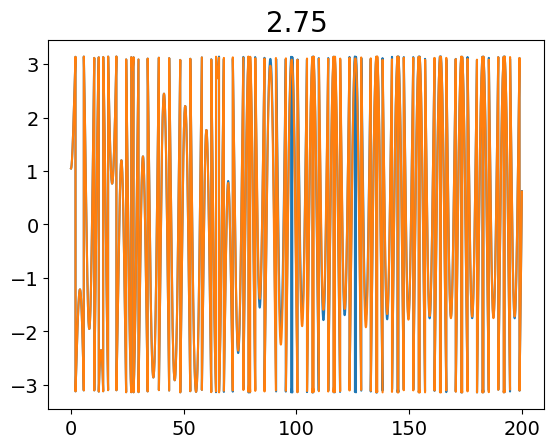

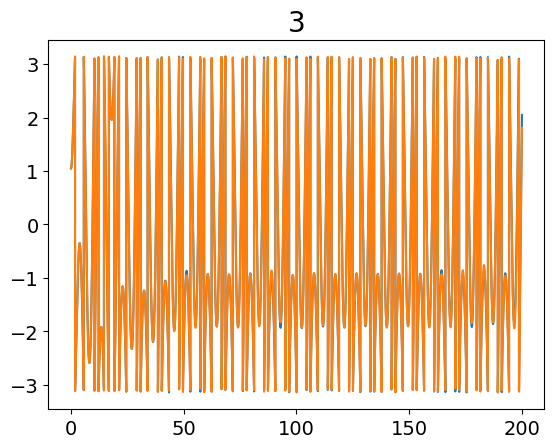

In [110]:
tmax = 200
dt = 0.02
ts = np.arange(0.0, tmax, dt)

def pendulum_2(theta, B):
    Xs = []
    for i, th in enumerate(theta):
        r = integrate.solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=B), 
                                (0.0, tmax), [th, 0], 
                                method="RK45", dense_output=True)
        
        Xs.append(r.sol(ts)[0])
    return ts, Xs

for b in [0.5, 0.75, 1, 1.25 ,1.5, 1.75, 2, 2.25, 2.5, 2.75 ,3]:
    T, X = pendulum_2([np.pi/3, np.pi/3 + 1e-5], b)
    for x in X:
        plt.plot(T, restrict_theta(x))
        plt.title(b)
    plt.show()

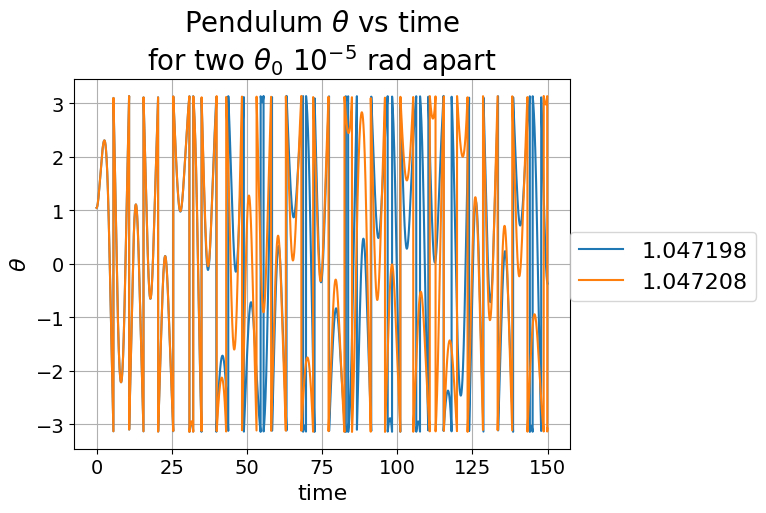

In [122]:
tmax = 150
dt = 0.02
ts = np.arange(0.0, tmax, dt)

# biggest difference observed for b = 2
thetas = [np.pi/3, np.pi/3 + 1e-5]
T, X = pendulum_2(thetas, 2)
plt.figure(dpi=100)
for x, th in zip(X, thetas):
    plt.plot(T, restrict_theta(x), label=f"{th:.6f}")
plt.title(r'Pendulum $\theta$ vs time'+'\n'+r'for two $\theta_0$ $10^{-5}$ rad apart')
plt.xlabel('time')
plt.ylabel(r'$\theta$')
plt.legend(loc=(1, 0.4))
plt.grid()
plt.show()